In [2]:
import pandas as pd

houses =pd.read_csv('version_D.csv')
houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27300 entries, 0 to 27299
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       27300 non-null  int64  
 1   bathrooms      27300 non-null  float64
 2   area           27300 non-null  int64  
 3   lot_size       27300 non-null  float64
 4   floors         27300 non-null  int64  
 5   age            27300 non-null  int64  
 6   garage         27300 non-null  int64  
 7   fireplace      27300 non-null  int64  
 8   renovated      27300 non-null  int64  
 9   neighborhood   27300 non-null  int64  
 10  distance_city  27300 non-null  float64
 11  price          27300 non-null  float64
 12  price_hilo     27300 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 2.7 MB


In [4]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
y = houses.price
X = houses.drop(['price','price_hilo'], axis = 1)
y_binned = pd.qcut(y, q = 100)
X_train, X_test, y_train, y_test = train_test_split(X,y,
                                                    random_state=617, 
                                                    train_size=0.7, 
                                                    stratify=y_binned)

avg_lot_size = X_train["lot_size"].mean()
avg_lot_size                                                  

3986.2841444270016

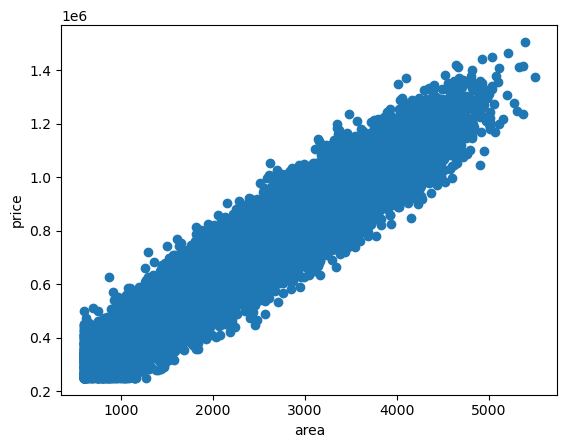

In [6]:
import matplotlib.pyplot as plt
train = X_train.assign(price = y_train)
test = X_test.assign(price = y_test)

plt.scatter(train['area'], train['price'])
plt.xlabel('area')
plt.ylabel('price')
plt.show()


In [7]:
from scipy.stats import pearsonr

vars_to_test = ["bedrooms","bathrooms","area","lot_size","floors","age"]

results = {}
for v in vars_to_test:
    r, p = pearsonr(train[v], train["price"])
    results[v] = p

results


{'bedrooms': 0.0,
 'bathrooms': 0.0,
 'area': 0.0,
 'lot_size': 1.9444207899155185e-54,
 'floors': 0.1927614149284777,
 'age': 1.9798499430716983e-05}

In [8]:
import statsmodels.api as sm

train = X_train.assign(price=y_train)

X_bath = sm.add_constant(train["bathrooms"])
model1 = sm.OLS(train["price"], X_bath).fit()
print(model1.params)


const        122994.154850
bathrooms    175301.381696
dtype: float64


In [9]:
train = X_train.assign(price=y_train)

X_nb = sm.add_constant(train["neighborhood"])
model2 = sm.OLS(train["price"], X_nb).fit()
print(model2.params)


const           730054.720142
neighborhood     92029.743356
dtype: float64


In [ ]:

train = X_train.assign(price=y_train)

X_full = sm.add_constant(train.drop("price", axis=1))
model3 = sm.OLS(train["price"], X_full).fit()
print(model3.rsquared)


0.945750602960582


In [11]:
model3.pvalues


const             0.000000e+00
bedrooms          8.056010e-30
bathrooms         1.040772e-56
area              0.000000e+00
lot_size          0.000000e+00
floors            5.588340e-01
age               5.408216e-01
garage           2.794531e-145
fireplace         2.376248e-40
renovated        1.073702e-147
neighborhood      0.000000e+00
distance_city     0.000000e+00
dtype: float64

In [12]:
vars_poly = ["bedrooms","bathrooms","area","lot_size","floors","age","distance_city"]

df_poly = train.copy()
for v in vars_poly:
    df_poly[v+"_sq"] = df_poly[v]**2

X_poly = sm.add_constant(df_poly[vars_poly + [v+"_sq" for v in vars_poly]])
model4 = sm.OLS(df_poly["price"], X_poly).fit()
print(model4.pvalues)

const               1.237327e-304
bedrooms             7.282660e-04
bathrooms            1.023586e-02
area                 0.000000e+00
lot_size             3.079171e-99
floors               6.278649e-01
age                  4.191766e-25
distance_city       2.533593e-260
bedrooms_sq          4.464794e-01
bathrooms_sq         4.357595e-01
area_sq              7.042761e-01
lot_size_sq          8.996889e-01
floors_sq            6.928434e-01
age_sq               2.381429e-16
distance_city_sq     4.666486e-01
dtype: float64


In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

train = X_train.assign(price=y_train)
X_full = train.drop("price", axis=1)
X_full_const = sm.add_constant(X_full)

vif_df = pd.DataFrame()
vif_df["variable"] = X_full_const.columns
vif_df["vif"] = [variance_inflation_factor(X_full_const.values, i) for i in range(X_full_const.shape[1])]
print(vif_df)


In [17]:
from sklearn.linear_model import LinearRegression
from mlxtend.feature_selection import SequentialFeatureSelector as SFS
train = X_train.assign(price=y_train)

X_subset = train[['bedrooms', 'bathrooms', 'area', 'lot_size', 'floors', 'distance_city', 'age']]
y_subset = train['price']

lr = LinearRegression()

sfs_backward = SFS(lr, 
                   k_features='best', 
                   forward=False, 
                   floating=False, 
                   scoring='r2', 
                   cv=5)

sfs_backward = sfs_backward.fit(X_subset, y_subset)

print(sfs_backward.k_feature_names_)

('bedrooms', 'bathrooms', 'area', 'lot_size', 'distance_city', 'age')


In [21]:
from sklearn.linear_model import LassoCV
from sklearn.preprocessing import StandardScaler

train = X_train.assign(price=y_train)

X_subset = train[['bedrooms', 'bathrooms', 'area', 'lot_size', 'floors', 'age', 'distance_city']]
y_subset = train['price']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_subset)

lasso_cv = LassoCV(cv=5, random_state=617)
lasso_cv.fit(X_scaled, y_subset)

coef_df = pd.DataFrame({'variable': X_subset.columns, 'coefficient': lasso_cv.coef_})
print(coef_df)

        variable    coefficient
0       bedrooms   11077.407412
1      bathrooms   13903.155545
2           area  176844.561272
3       lot_size   23849.793390
4         floors     -47.630514
5            age   -3379.167451
6  distance_city  -47758.926572


In [27]:
from sklearn.tree import DecisionTreeRegressor

tree = DecisionTreeRegressor(max_depth=4, random_state=617)
tree.fit(X_train, y_train)

importance_df = pd.DataFrame({'variable': X_train.columns, 'importance': tree.feature_importances_})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)

         variable  importance
2            area    0.951519
9    neighborhood    0.048481
0        bedrooms    0.000000
1       bathrooms    0.000000
3        lot_size    0.000000
4          floors    0.000000
5             age    0.000000
6          garage    0.000000
7       fireplace    0.000000
8       renovated    0.000000
10  distance_city    0.000000


In [28]:
new_house = pd.DataFrame({
    'bedrooms': [3],
    'bathrooms': [1],
    'area': [2000],
    'lot_size': [3000],
    'floors': [2],
    'age': [30],
    'garage': [1],
    'fireplace': [1],
    'renovated': [1],
    'neighborhood': [1],
    'distance_city': [10]
})

prediction = tree.predict(new_house)
prediction

array([675840.50541928])

In [29]:
new_house = pd.DataFrame({
    'bedrooms': [3],
    'bathrooms': [2],
    'area': [1500],
    'lot_size': [2000],
    'floors': [1],
    'age': [90],
    'garage': [0],
    'fireplace': [0],
    'renovated': [0],
    'neighborhood': [0],
    'distance_city': [10]
})

prediction = tree.predict(new_house)
print(prediction[0])

481369.247005988


In [34]:
from sklearn.model_selection import GridSearchCV


tree = DecisionTreeRegressor(random_state=617)

param_grid = {'max_depth': [4, 5, 6, 7, 8]}

grid_search = GridSearchCV(tree, param_grid, cv=5, scoring='neg_root_mean_squared_error')
grid_search.fit(X_train, y_train)

results = pd.DataFrame(grid_search.cv_results_)
results['RMSE'] = -results['mean_test_score']
print(results[['param_max_depth', 'RMSE']].sort_values('RMSE'))

  param_max_depth          RMSE
4               8  58606.361899
3               7  59317.977652
2               6  61411.015268
1               5  64281.592943
0               4  69929.112033


In [36]:
from sklearn.ensemble import BaggingRegressor
from sklearn.metrics import mean_squared_error
bagging = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=10),
                           n_estimators=100,
                           random_state=617)

bagging.fit(X_train, y_train)

y_train_pred = bagging.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(rmse_train)

43251.81143193673


In [37]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_estimators=100, random_state=617)
rf.fit(X_train, y_train)

y_train_pred = rf.predict(X_train)
rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
print(rmse_train)

19871.91955896542


In [38]:
importance_df = pd.DataFrame({'variable': X_train.columns, 'importance': rf.feature_importances_})
importance_df = importance_df.sort_values('importance', ascending=False)
print(importance_df)

         variable  importance
2            area    0.882954
9    neighborhood    0.044006
3        lot_size    0.025063
10  distance_city    0.022769
5             age    0.010729
1       bathrooms    0.004042
0        bedrooms    0.002568
6          garage    0.002273
4          floors    0.001993
8       renovated    0.001900
7       fireplace    0.001703


In [42]:

houses = pd.read_csv('version_D.csv')

y = houses.price 
X = houses.drop(['price','price_hilo'], axis = 1) 

y_class = houses.price_hilo
X_class_train, X_class_test, y_class_train, y_class_test = train_test_split(X, y_class,
                                                                            train_size=0.7, 
                                                                            random_state=617,
                                                                            stratify=y_class)

train_class = X_class_train.assign(price_hilo = y_class_train)
test_class = X_class_test.assign(price_hilo = y_class_test)

In [45]:
train_class.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19110 entries, 12042 to 4571
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bedrooms       19110 non-null  int64  
 1   bathrooms      19110 non-null  float64
 2   area           19110 non-null  int64  
 3   lot_size       19110 non-null  float64
 4   floors         19110 non-null  int64  
 5   age            19110 non-null  int64  
 6   garage         19110 non-null  int64  
 7   fireplace      19110 non-null  int64  
 8   renovated      19110 non-null  int64  
 9   neighborhood   19110 non-null  int64  
 10  distance_city  19110 non-null  float64
 11  price_hilo     19110 non-null  int64  
dtypes: float64(3), int64(9)
memory usage: 1.9 MB


In [43]:
import statsmodels.formula.api as smf
model = smf.logit('price_hilo ~ bedrooms + bathrooms + area + lot_size + floors + age + garage + fireplace + renovated + neighborhood + distance_city', data=train_class).fit()

print(model.summary())

Optimization terminated successfully.
         Current function value: 0.162960
         Iterations 10
                           Logit Regression Results                           
Dep. Variable:             price_hilo   No. Observations:                19110
Model:                          Logit   Df Residuals:                    19098
Method:                           MLE   Df Model:                           11
Date:                Wed, 03 Dec 2025   Pseudo R-squ.:                  0.7649
Time:                        02:13:38   Log-Likelihood:                -3114.2
converged:                       True   LL-Null:                       -13246.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept       -24.1294      0.484    -49.871      0.000     -25.078     -23.181
bedrooms          0

In [47]:
coef_bathrooms = model.params['bathrooms']
odds_ratio = np.exp(coef_bathrooms)

odds_ratio

1.574924129179654

In [49]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score
logreg = LogisticRegression(max_iter=10000, random_state=617)
logreg.fit(X_class_train, y_class_train)

y_train_prob = logreg.predict_proba(X_class_train)[:, 1]
auc_train = roc_auc_score(y_class_train, y_train_prob)
print(auc_train)

0.9837810511235046


In [52]:
from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_class_train)

svm = SVC(kernel='rbf', C=1, random_state=617)
svm.fit(X_train_scaled, y_class_train)

y_train_pred = svm.predict(X_train_scaled)
accuracy_train = accuracy_score(y_class_train, y_train_pred)
print(accuracy_train)




0.9316064887493459


In [54]:
X_test_scaled = scaler.transform(X_class_test)
y_test_pred = svm.predict(X_test_scaled)
accuracy_test = accuracy_score(y_class_test, y_test_pred)
print(accuracy_test)

0.9277167277167278
